# Topic Modeling
One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s packages. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. 

##  with Gensim

Knowing what papers are talking about and understanding their problems and opinions is highly valuable. And it’s really hard to manually read through such large volumes and compile the topics. Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this notebook, I use the dataset provided by Abassi Nour Ghalia (nour.abassi@epﬂ.ch) Guillain Léonore Valentine (leonore.guillain@epﬂ.ch) and use LDA to extract the naturally discussed topics.

Firstly, I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

This part will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

### Import Packages
The core packages used are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhenchensu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Prepare Stopwords
We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'cscl', 'edu', 'use', 'et_al'])

### Import data from papers
Here we use os.walk go through the data root file and import papers by `parse` function. 

As results, we get a list `contents` which has textual data of each pdf. Then tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether, '\n' for example. Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

The output is stored in `data_words` as a list of words

In [3]:
def parse(file_path): 
    i = 0 
    tmp = ''
    key = ''
    xml2 =etree.iterparse(file_path, recover=True)
    data = []
    for action, elem in xml2:
        data.append((elem.attrib,elem.text))
    data_dict = {}
    l = set()
    for elem in data: 
        try : 
            tmp = key 
            key = elem[0].get('qualifier')
            if key == 'author':
                l.add(elem[1])
                data_dict[key] = l
                if tmp == key:
                    l.add(elem[1])
                    data_dict[key] = l
                else : 
                    l = set()
            else : 
                data_dict[key] = elem[1]
        except TypeError: 
                data_dict['None'] = elem[1]
    return data_dict

In [69]:
import os
rootdir = 'data/papers'
contents = []
i = 0
num_2015 = 0
num_2016 = 0
num_2017 = 0
num_2018 = 0
source = []
errors = []
for subdir, dirs, files in os.walk(rootdir):
    files.sort()
    for file in files:
        if 'txt' in file:
            i += 1
            if '2015' in file:
                num_2015 += 1
            if '2016' in file:
                num_2016 += 1
            if '2017' in file:
                num_2017 += 1
            if '2018' in file:
                num_2018 += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(subdir[len(rootdir):])
                except:
                    name, message, content = sys.exc_info()
                    errors.append(message)


In [70]:
len(contents)

874

In [81]:
time_slice = [num_2015, num_2016,num_2017, num_2018]
time_slice

[142, 171, 115, 446]

In [72]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))

print(data_words[:1])

[['that', 'what', 'everyone', 'else', 'is', 'saying', 'collaborative', 'reflection', 'in', 'action', 'during', 'creative', 'activities', 'michael', 'downton', 'st', 'john', 'university', 'downtonm', 'stjohns', 'edu', 'abstract', 'with', 'the', 'progression', 'of', 'more', 'user', 'friendly', 'music', 'production', 'software', 'packages', 'apple', 'garageband', 'and', 'the', 'importance', 'of', 'social', 'media', 'learners', 'are', 'engaging', 'with', 'music', 'without', 'having', 'any', 'formal', 'education', 'on', 'important', 'musical', 'concepts', 'it', 'has', 'been', 'suggested', 'that', 'novice', 'music', 'learners', 'should', 'start', 'with', 'what', 'they', 'know', 'how', 'to', 'intuitively', 'do', 'already', 'which', 'will', 'allow', 'them', 'to', 'move', 'to', 'more', 'sophisticated', 'musical', 'concepts', 'notation', 'intervals', 'however', 'music', 'production', 'is', 'becoming', 'more', 'group', 'project', 'than', 'solitary', 'one', 'in', 'which', 'everyone', 'in', 'group'

### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our context are: ‘problem_solving’, ‘New_york' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these parameters are, the harder it is for words to be combined to bigrams.

In [73]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['that', 'what', 'everyone_else', 'is', 'saying', 'collaborative', 'reflection', 'in', 'action', 'during', 'creative', 'activities', 'michael', 'downton', 'st', 'john', 'university', 'downtonm', 'stjohns', 'edu_abstract', 'with', 'the', 'progression', 'of', 'more', 'user_friendly', 'music_production', 'software', 'packages', 'apple', 'garageband', 'and', 'the', 'importance', 'of', 'social_media', 'learners', 'are', 'engaging', 'with', 'music', 'without', 'having', 'any', 'formal', 'education', 'on', 'important', 'musical', 'concepts', 'it', 'has_been', 'suggested', 'that', 'novice', 'music', 'learners', 'should', 'start', 'with', 'what', 'they', 'know', 'how', 'to', 'intuitively', 'do', 'already', 'which', 'will', 'allow', 'them', 'to', 'move', 'to', 'more', 'sophisticated_musical', 'concepts', 'notation', 'intervals', 'however', 'music_production', 'is', 'becoming', 'more', 'group', 'project', 'than', 'solitary', 'one', 'in', 'which', 'everyone', 'in', 'group', 'has', 'voice', 'fourth

### Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready.  
Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [74]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#import snowballstemmer to uniform words
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def lemmatization_(texts):
    texts_out = []
    for sent in texts:
        doc = []
        for word in sent:
            doc.append(stemmer.stem(word))
        texts_out.append(doc)
    return texts_out

In [75]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization_(data_words_bigrams)

print(data_lemmatized[:1])

[['everyone_els', 'say', 'collabor', 'reflect', 'action', 'creativ', 'activ', 'michael', 'downton', 'st', 'john', 'univers', 'downtonm', 'stjohn', 'abstract', 'progress', 'user_friend', 'music_product', 'softwar', 'packag', 'appl', 'garageband', 'import', 'social', 'media', 'learner', 'engag', 'music', 'without', 'formal', 'educ', 'import', 'music', 'concept', 'suggest', 'novic', 'music', 'learner', 'start', 'know', 'intuit', 'alreadi', 'allow', 'move', 'sophisticated_mus', 'concept', 'notat', 'interv', 'howev', 'music_product', 'becom', 'group', 'project', 'solitari', 'one', 'everyon', 'group', 'voic', 'fourth_grad', 'classroom', 'engag', 'music', 'curriculum', 'use', 'learn', 'software_impromptu', 'findings_suggest', 'student', 'abl', 'reflect', 'action', 'reflect', 'becom', 'build', 'block', 'other', 'group', 'add', 'knowledg', 'base', 'keyword', 'music', 'intuit', 'social', 'negoti', 'introduct', 'sinc', 'releas', 'popular', 'musician', 'learn', 'green', 'stark', 'divid', 'field', 

### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 6), (1, 1), (2, 1), (3, 1), (4, 3), (5, 15), (6, 29), (7, 1), (8, 2), (9, 2), (10, 3), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 5), (18, 1), (19, 7), (20, 1), (21, 8), (22, 6), (23, 1), (24, 1), (25, 1), (26, 2), (27, 5), (28, 2), (29, 1), (30, 1), (31, 3), (32, 1), (33, 2), (34, 1), (35, 2), (36, 1), (37, 8), (38, 1), (39, 2), (40, 3), (41, 1), (42, 1), (43, 5), (44, 2), (45, 1), (46, 2), (47, 1), (48, 2), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 19), (64, 2), (65, 9), (66, 1), (67, 5), (68, 4), (69, 9), (70, 1), (71, 2), (72, 1), (73, 1), (74, 16), (75, 1), (76, 4), (77, 1), (78, 2), (79, 2), (80, 1), (81, 2), (82, 1), (83, 4), (84, 1), (85, 1), (86, 15), (87, 1), (88, 1), (89, 1), (90, 1), (91, 3), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 15), (104, 2), (105, 4), (106, 1), (107, 2), (108, 5), (109, 1), (1

### Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [77]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [78]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"teacher" + 0.029*"learn" + 0.021*"student" + 0.017*"educ" + '
  '0.014*"classroom" + 0.014*"research" + 0.014*"practic" + 0.013*"scienc" + '
  '0.012*"teach" + 0.011*"design"'),
 (1,
  '0.021*"learn" + 0.021*"social" + 0.018*"cours" + 0.017*"onlin" + '
  '0.015*"interact" + 0.012*"student" + 0.012*"discuss" + 0.010*"content" + '
  '0.009*"mooc" + 0.009*"peer"'),
 (2,
  '0.000*"santannapisa" + 0.000*"saturnino" + 0.000*"ridg" + 0.000*"ruffaldi" '
  '+ 0.000*"sai" + 0.000*"salter" + 0.000*"sant" + 0.000*"regressor" + '
  '0.000*"scuola" + 0.000*"semiact"'),
 (3,
  '0.016*"okc" + 0.011*"nistor" + 0.008*"blogger" + 0.003*"non_integr" + '
  '0.003*"walden" + 0.003*"integrate_newcom" + 0.002*"wenger" + 0.002*"nicola" '
  '+ 0.002*"integrative_okc" + 0.002*"baker_siemen"'),
 (4,
  '0.071*"student" + 0.023*"model" + 0.014*"scienc" + 0.012*"use" + '
  '0.012*"design" + 0.010*"comput" + 0.008*"learn" + 0.008*"idea" + '
  '0.007*"task" + 0.007*"base"'),
 (5,
  '0.031*"learn" + 0.01

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [79]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.732499652598227

Coherence Score:  0.3701296740144457


### Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [80]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      14.318149        1       1  0.177738  0.020543
11     13.660413        1       2  0.155017  0.053008
4      12.979026        1       3  0.175381  0.019306
5      11.881598        1       4  0.177416 -0.057703
12      9.095840        1       5  0.175791  0.066558
19      5.864030        1       6  0.153791  0.037070
8       5.800504        1       7  0.132839 -0.108387
1       5.414269        1       8  0.147241 -0.087982
9       4.487537        1       9  0.127413 -0.037603
7       3.950249        1      10  0.119788 -0.071849
15      3.380083        1      11  0.101821  0.020470
13      3.357337        1      12  0.121667 -0.070736
17      3.192179        1      13  0.091231  0.145885
16      1.354973        1      14  0.038184  0.228334
6       0.842947        1      15 -0.106538 -0.208445
14      0.287255        1      16 -0.330270 -0.017569
18      0.118562        1      17 -0.363427  0.025710
3       0.014435        1      18 -0.366896  0.014824
10      0.000310        1      19 -0.364093  0.014283
2       0.000305        1      20 -0.364093  0.014283, topic_info=      Category          Freq              Term         Total  loglift  logprob
term                                                                          
6123   Default  34594.000000           student  34594.000000  30.0000  30.0000
13456  Default  12456.000000             group  12456.000000  29.0000  29.0000
29707  Default  12013.000000           teacher  12013.000000  28.0000  28.0000
21739  Default  10577.000000          collabor  10577.000000  27.0000  27.0000
298    Default  14722.000000            design  14722.000000  26.0000  26.0000
17914  Default  10871.000000          knowledg  10871.000000  25.0000  25.0000
9941   Default   2656.000000              team   2656.000000  24.0000  24.0000
24046  Default  30897.000000             learn  30897.000000  23.0000  23.0000
32236  Default   7068.000000             model   7068.000000  22.0000  22.0000
20095  Default   5553.000000           learner   5553.000000  21.0000  21.0000
12272  Default   3179.000000          mathemat   3179.000000  20.0000  20.0000
29786  Default   3248.000000              role   3248.000000  19.0000  19.0000
12722  Default   3443.000000           project   3443.000000  18.0000  18.0000
21911  Default   2081.000000           network   2081.000000  17.0000  17.0000
586    Default   5559.000000              idea   5559.000000  16.0000  16.0000
13712  Default  12464.000000            scienc  12464.000000  15.0000  15.0000
31310  Default   4746.000000         communiti   4746.000000  14.0000  14.0000
28048  Default   2558.000000              play   2558.000000  13.0000  13.0000
13771  Default   3652.000000              tool   3652.000000  12.0000  12.0000
25836  Default   7439.000000          interact   7439.000000  11.0000  11.0000
32308  Default   3098.000000          discours   3098.000000  10.0000  10.0000
6850   Default   4169.000000             build   4169.000000   9.0000   9.0000
26857  Default   8593.000000             activ   8593.000000   8.0000   8.0000
7064   Default   5553.000000           analysi   5553.000000   7.0000   7.0000
26069  Default   3075.000000           inquiri   3075.000000   6.0000   6.0000
21166  Default   1950.000000              text   1950.000000   5.0000   5.0000
19346  Default   4891.000000         technolog   4891.000000   4.0000   4.0000
18901  Default   1521.000000             simul   1521.000000   3.0000   3.0000
18429  Default   1717.000000            gestur   1717.000000   2.0000   2.0000
22423  Default   2541.000000           connect   2541.000000   1.0000   1.0000
...        ...           ...               ...           ...      ...      ...
4198   Topic20      0.000161             orbit      1.062839   3.9014 -10.4074
11054  Topic20      0.000161             mutat    112.431587  -0.7600 -10.4074
1102

We can see from the graph that since these papers are from same conference and most of them use nearly same word distribution, most of the topics we got locate in same area. This is a reasonalble and good explanation. So what we need to do is to improve this model and make topics more diverse.

### Building LDA Mallet Model
So far we have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [17]:
mallet_path = './mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('knowledg', 0.051027029326979334),
   ('student', 0.044899956387154424),
   ('build', 0.026423002052994925),
   ('idea', 0.023550936612452),
   ('inquiri', 0.019189652054590518),
   ('discours', 0.016934548819793848),
   ('communiti', 0.014860279334957292),
   ('note', 0.012062674850280293),
   ('question', 0.0104351711006393),
   ('collect', 0.009669286983161187)]),
 (13,
  [('game', 0.058513959504058514),
   ('play', 0.028133083578628135),
   ('student', 0.02442244224422442),
   ('learn', 0.019034876460619035),
   ('activ', 0.015003121933815004),
   ('design', 0.010864329676210864),
   ('base', 0.008759254303808759),
   ('engag', 0.00825974489340826),
   ('player', 0.008117027919008117),
   ('system', 0.007688876995807689)]),
 (3,
  [('communiti', 0.019314864315541812),
   ('scienc', 0.017565686552272083),
   ('ident', 0.014276739631194491),
   ('particip', 0.013660831968071347),
   ('practic', 0.01090156563727966),
   ('posit', 0.009780613690395536),
   ('stem', 0.009201660

Actually, accroding to the coherence scorce(0.37) we got is a little bit lower than we achieve before. So we decide to use the inbuild version instead of Mallet model.

### Find the optimal number of topics
The usual approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.


The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.



In [83]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [84]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=100, step=1)

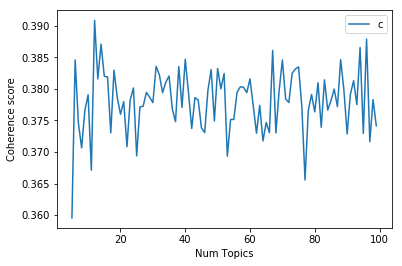

In [86]:
# Show graph
limit=100; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [87]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 5  has Coherence Value of 0.3596
Num Topics = 6  has Coherence Value of 0.3846
Num Topics = 7  has Coherence Value of 0.3746
Num Topics = 8  has Coherence Value of 0.3707
Num Topics = 9  has Coherence Value of 0.3766
Num Topics = 10  has Coherence Value of 0.3791
Num Topics = 11  has Coherence Value of 0.3671
Num Topics = 12  has Coherence Value of 0.3909
Num Topics = 13  has Coherence Value of 0.3816
Num Topics = 14  has Coherence Value of 0.3871
Num Topics = 15  has Coherence Value of 0.382
Num Topics = 16  has Coherence Value of 0.3819
Num Topics = 17  has Coherence Value of 0.373
Num Topics = 18  has Coherence Value of 0.383
Num Topics = 19  has Coherence Value of 0.3787
Num Topics = 20  has Coherence Value of 0.376
Num Topics = 21  has Coherence Value of 0.378
Num Topics = 22  has Coherence Value of 0.3708
Num Topics = 23  has Coherence Value of 0.3783
Num Topics = 24  has Coherence Value of 0.3801
Num Topics = 25  has Coherence Value of 0.3694
Num Topics = 26  has Co

We can see the score line is not quite regular but overall there is a limitation at 0.385. Although choosing higher topic numbers may reach higher performance, it cannot explain itself. 

So for further steps I will choose the model with 12 topics which is an adequate topic amount.



In [177]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"student" + 0.029*"model" + 0.021*"scienc" + 0.012*"design" + '
  '0.011*"idea" + 0.010*"comput" + 0.010*"learn" + 0.010*"simul" + '
  '0.009*"group" + 0.008*"base"'),
 (1,
  '0.046*"student" + 0.023*"cours" + 0.022*"learn" + 0.014*"peer" + '
  '0.014*"feedback" + 0.012*"reflect" + 0.011*"activ" + 0.011*"onlin" + '
  '0.011*"assess" + 0.010*"discuss"'),
 (2,
  '0.053*"student" + 0.029*"learn" + 0.018*"condit" + 0.016*"problem" + '
  '0.012*"activ" + 0.011*"effect" + 0.011*"instruct" + 0.010*"knowledg" + '
  '0.009*"studi" + 0.009*"solut"'),
 (3,
  '0.031*"group" + 0.016*"collabor" + 0.015*"analysi" + 0.014*"learn" + '
  '0.011*"team" + 0.010*"data" + 0.009*"interact" + 0.008*"differ" + '
  '0.008*"discuss" + 0.008*"network"'),
 (4,
  '0.034*"student" + 0.027*"scienc" + 0.015*"scientif" + 0.013*"data" + '
  '0.012*"evid" + 0.011*"practic" + 0.010*"reason" + 0.009*"question" + '
  '0.009*"discuss" + 0.008*"understand"'),
 (5,
  '0.048*"knowledg" + 0.044*"student" + 0.026*"i

Those were the topics for the chosen LDA model.

In [178]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      18.855909        1       1 -0.126645  0.040385
4      16.724270        1       2 -0.118741 -0.007026
11     16.405966        1       3 -0.101971 -0.049635
5      13.022558        1       4 -0.128011  0.080342
8      10.555316        1       5 -0.115448 -0.000864
9       6.695395        1       6 -0.060120  0.045758
7       5.438285        1       7 -0.071358  0.044325
6       4.762491        1       8 -0.054045 -0.003344
1       4.065299        1       9 -0.044798  0.089733
10      3.235897        1      10  0.004304 -0.289457
2       0.182553        1      11  0.410525  0.041673
3       0.056057        1      12  0.406307  0.008110, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
298    Default  15071.000000           design  15071.000000  30.0000  30.0000
29707  Default  12234.000000          teacher  12234.000000  29.0000  29.0000
17914  Default  10785.000000         knowledg  10785.000000  28.0000  28.0000
6123   Default  34851.000000          student  34851.000000  27.0000  27.0000
32236  Default   7011.000000            model   7011.000000  26.0000  26.0000
31310  Default   4694.000000        communiti   4694.000000  25.0000  25.0000
22423  Default   2392.000000          connect   2392.000000  24.0000  24.0000
17416  Default   2943.000000         children   2943.000000  23.0000  23.0000
21739  Default  10253.000000         collabor  10253.000000  22.0000  22.0000
21911  Default   1913.000000          network   1913.000000  21.0000  21.0000
24046  Default  30416.000000            learn  30416.000000  20.0000  20.0000
12272  Default   3099.000000         mathemat   3099.000000  19.0000  19.0000
32308  Default   3077.000000         discours   3077.000000  18.0000  18.0000
7305   Default   1422.000000          epistem   1422.000000  17.0000  17.0000
9941   Default   2938.000000             team   2938.000000  16.0000  16.0000
586    Default   5498.000000             idea   5498.000000  15.0000  15.0000
13456  Default  11536.000000            group  11536.000000  14.0000  14.0000
191    Default   5125.000000           social   5125.000000  13.0000  13.0000
25836  Default   7359.000000         interact   7359.000000  12.0000  12.0000
20095  Default   5292.000000          learner   5292.000000  11.0000  11.0000
18429  Default   1736.000000           gestur   1736.000000  10.0000  10.0000
6850   Default   4163.000000            build   4163.000000   9.0000   9.0000
13712  Default  12322.000000           scienc  12322.000000   8.0000   8.0000
3445   Default   2412.000000            onlin   2412.000000   7.0000   7.0000
15497  Default   3169.000000             code   3169.000000   6.0000   6.0000
31448  Default   2692.000000            cours   2692.000000   5.0000   5.0000
26069  Default   2953.000000          inquiri   2953.000000   4.0000   4.0000
21166  Default   1851.000000             text   1851.000000   3.0000   3.0000
12722  Default   3604.000000          project   3604.000000   2.0000   2.0000
26471  Default   2092.000000         feedback   2092.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
29803  Topic12      0.603521  richard_richard      1.714875   6.4422  -7.3881
3543   Topic12      0.603521       bryce_rutt      1.714875   6.4422  -7.3881
18905  Topic12      0.603521    mortal_kombat      1.714875   6.4422  -7.3881
10450  Topic12      0.603521      disidentifi      1.714875   6.4422  -7.3881
3929   Topic12      0.596640  jenkins_clinton      1.708014   6.4348  -7.3996
5751   Topic12      0.412738        belonging      1.524133   6.1802  -7.7681
12825  Topic12      0.410651             komi      1.522006   6.1765  -7.7732
3998   Topic12      0.410651            yando      1.522006   6.1765  -7.7732
110

### Finding the dominant topic in each paper
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [179]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=contents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=contents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3535,"student, cours, learn, peer, feedback, reflect...",“That’s What Everyone Else Is Saying…”:\nColla...
1,1,5.0,0.6462,"knowledg, student, idea, build, inquiri, disco...",The 3R Orchestration Cycle:\nFostering Multi-M...
2,2,5.0,0.4114,"knowledg, student, idea, build, inquiri, disco...",Principle-Based Guidance to Foster Adaptive Te...
3,3,1.0,0.6575,"student, cours, learn, peer, feedback, reflect...",Connected Biology: A Usability Study of Web 2....
4,4,5.0,0.5267,"knowledg, student, idea, build, inquiri, disco...",A Multivocality Approach to Epistemic Agency\n...
5,5,11.0,0.6758,"game, play, children, mathemat, interact, gest...",“This Is the Size of One Meter”: Children’s Bo...
6,6,11.0,0.5272,"game, play, children, mathemat, interact, gest...",The Development of Situational-Misconceptions\...
7,7,3.0,0.8223,"group, collabor, analysi, learn, team, data, i...",Dialogism:\nA Framework for CSCL and a Signatu...
8,8,11.0,0.4702,"game, play, children, mathemat, interact, gest...",Boundary Interactions: Resolving Interdiscipli...
9,9,9.0,0.4539,"teacher, learn, student, teach, school, practi...",Design Features for Computer-Supported Complex...


### Find the most representative document for each topic
This is the way to find out what is a topic about. 

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [180]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7834,"student, model, scienc, design, idea, comput, ...",Use of Interactive Computer Models to Promote ...
1,1.0,0.7393,"student, cours, learn, peer, feedback, reflect...",Mixing In-Class and Online Learning: Content M...
2,2.0,0.8619,"student, learn, condit, problem, activ, effect...",Learning From Errors – The Effect of Compariso...
3,3.0,0.8471,"group, collabor, analysi, learn, team, data, i...",Time and Semantic Similarity – What is the Bes...
4,4.0,0.8095,"student, scienc, scientif, data, evid, practic...",Secondary Students’ Evaluation of Inappropriat...


The tabular output above actually has 15 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [181]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1.0,"student, cours, learn, peer, feedback, reflect...",87.0,0.0995
1,5.0,"knowledg, student, idea, build, inquiri, disco...",59.0,0.0675
2,5.0,"knowledg, student, idea, build, inquiri, disco...",53.0,0.0606
3,1.0,"student, cours, learn, peer, feedback, reflect...",63.0,0.0721
4,5.0,"knowledg, student, idea, build, inquiri, disco...",81.0,0.0927
5,11.0,"game, play, children, mathemat, interact, gest...",57.0,0.0652
6,11.0,"game, play, children, mathemat, interact, gest...",94.0,0.1076
7,3.0,"group, collabor, analysi, learn, team, data, i...",49.0,0.0561
8,11.0,"game, play, children, mathemat, interact, gest...",71.0,0.0812
9,9.0,"teacher, learn, student, teach, school, practi...",76.0,0.0870


## Dynamic topic modeling

In [93]:
# Build LDA seq model
from gensim.models import ldaseqmodel
ldaseq_model = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slice, num_topics=15)

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:296: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeW

In [206]:
import seaborn as sns
def print_topic_change(topic=0, top_terms=10):
    df_time = pd.DataFrame()
    t=ldaseq_model.print_topic_times(topic=topic,top_terms=top_terms)
    for i in range(len(t)):
        temp = pd.DataFrame(t[i], columns=['word', 'value'])
        temp['year'] = 2015 + i 
        df_time = pd.concat([df_time, temp])
    # Line plot
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='year', y='value',
                      hue="word", markers=True, dashes=False, data=df_time)
    plt.legend(loc='upper right')
    plt.xticks([2015, 2016, 2017, 2018])

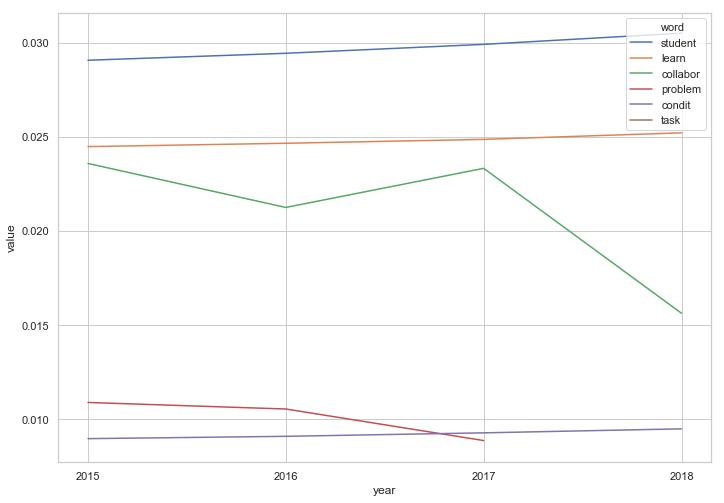

In [226]:
print_topic_change(topic=0, top_terms=5)

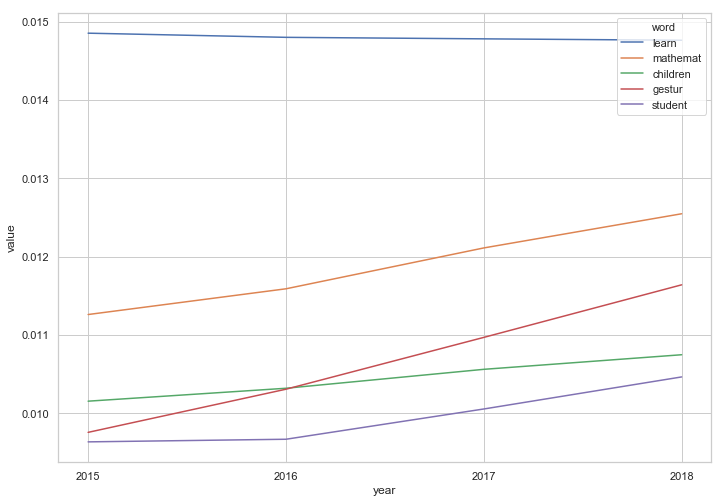

In [229]:
print_topic_change(topic=3, top_terms=5)

### With sklearn
With LDA using gensim, topics cannot separate obviously. In this part, we are going to employ LDA in sklearn library which can provide a different point of view.

With scikit learn, we have an entirely different interface and with grid search and vectorizers, you have a lot of options to explore in order to find the optimal model and to present the results.

In [33]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

### Tokenize and Clean-up using gensim’s simple_preprocess()
This part is done by gensim section, so we can use data_words directly.

In [34]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data_words = list(sent_to_words(contents))

# print(data_words[:1])


### Lemmatization
Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

We can expect better topics to be generated in the end.


In [35]:
def lemmatization(texts):
    texts_out = []
    for sent in texts:
        doc = ''
        for word in sent:
            doc = doc + ' ' + stemmer.stem(word) 
        texts_out.append(doc)
    return texts_out

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words)

print(data_lemmatized[2])

 open the door to algebra the role of fraction knowledg in algebra learn juli booth templ univers juli booth templ edu kristi newton templ univers kkjone templ edu laura pendergast templ univers lhpendergast gmail com christina barbieri univers of delawar barbieri udel edu abstract we examin th th and th grade class in order to determin how fraction knowledg improv natur dure busi as usual instruct and whether natur occur improv in fraction knowledg are relat to improv in algebra readi achiev outcom signific recent research has confirm specul of scholar and practition alik student knowledg about fraction is predict of their algebra readi booth newton and perform and learn in algebra booth newton twiss garriti howev the mechan under the relat between fraction knowledg and improv algebra perform and learn are yet unclear especi as the benefit of fraction knowledg appear even when student solv problem that do not involv fraction in the present studi we examin natur occur chang over the co

### Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

We create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 20 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

In [36]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=20,                        # minimum reqd occurences of a word 
                             max_df=0.8,
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

### Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [37]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  14.385770068707618 %


### Build LDA model with sklearn
Everything is ready to build a Latent Dirichlet Allocation (LDA) model. I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [38]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [39]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -8492942.273485389
Perplexity:  1042.385250329062
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### GridSearch the best model
The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.


In [40]:
# Define Search Param
search_params = {'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Best topic model and its parameters


In [41]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_topics': 10}
Best Log Likelihood Score:  -2926195.4076326615
Model Perplexity:  1080.124502458776


### Compare LDA Model Performance Scores
Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.9 outperforms both 0.5 and 0.7.

In [42]:
results_df = pd.DataFrame(model.cv_results_)
results_df.head()

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_decay,param_n_topics,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,10.011033,0.489622,-2.927605e+06,-5.701374e+06,0.5,10,"{'learning_decay': 0.5, 'n_topics': 10}",2,-3.045214e+06,-5.589386e+06,-2.870898e+06,-5.744391e+06,-2.866299e+06,-5.770344e+06,1.293131,0.085455,83326.020966,79892.830722
1,11.540748,0.546270,-2.945426e+06,-5.686918e+06,0.5,15,"{'learning_decay': 0.5, 'n_topics': 15}",6,-3.057435e+06,-5.567127e+06,-2.895285e+06,-5.746165e+06,-2.883174e+06,-5.747463e+06,0.286983,0.005889,79492.130064,84707.153939
2,12.187218,0.607444,-2.955190e+06,-5.662960e+06,0.5,20,"{'learning_decay': 0.5, 'n_topics': 20}",8,-3.074707e+06,-5.554421e+06,-2.899012e+06,-5.714983e+06,-2.891439e+06,-5.719475e+06,0.160392,0.012533,84713.162692,76770.439338
3,13.380096,0.719434,-2.971739e+06,-5.659881e+06,0.5,25,"{'learning_decay': 0.5, 'n_topics': 25}",10,-3.091625e+06,-5.564249e+06,-2.918347e+06,-5.704010e+06,-2.904835e+06,-5.711384e+06,0.038227,0.055811,85096.250186,67688.864125
4,14.578943,0.726234,-2.985087e+06,-5.653304e+06,0.5,30,"{'learning_decay': 0.5, 'n_topics': 30}",13,-3.100440e+06,-5.545414e+06,-2.931755e+06,-5.705818e+06,-2.922670e+06,-5.708679e+06,0.206204,0.014956,81790.542205,76298.534968


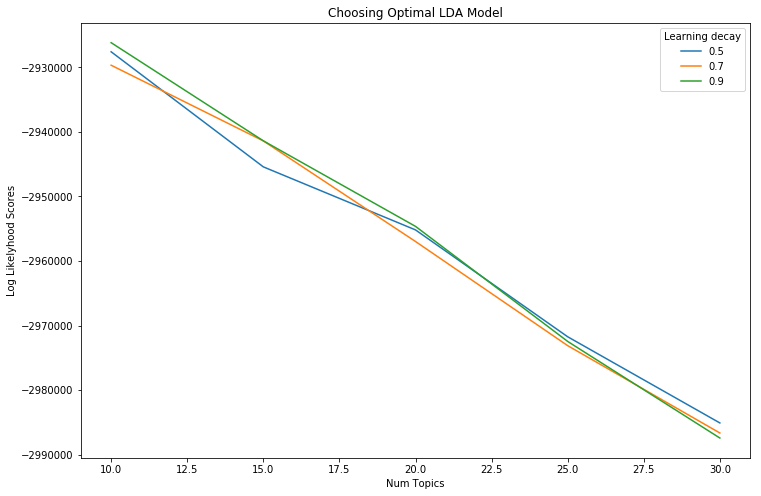

In [43]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[0][1].values.tolist())
log_likelyhoods_7 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[1][1].values.tolist())
log_likelyhoods_9 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[2][1].values.tolist())

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [44]:
np.log(abs(log_likelyhoods_7))

array([14.89040581, 14.89439758, 14.89968039, 14.90512112, 14.90966024])

### Dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [45]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [46]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(contents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0.7,0.1,0.04,0.16,0,0,0,3
Doc1,0,0,0.34,0.06,0.15,0,0.06,0.24,0.07,0.08,2
Doc2,0,0.7,0,0,0.04,0,0,0.13,0,0.13,1
Doc3,0.44,0.14,0.08,0.04,0.19,0,0.11,0,0,0,0
Doc4,0,1,0,0,0,0,0,0,0,0,1
Doc5,0,0.1,0,0,0,0,0,0.9,0,0,7
Doc6,0.01,0.04,0,0.62,0.16,0.04,0.14,0,0,0,3
Doc7,0.05,0,0.04,0.04,0.11,0.07,0.08,0,0,0.6,9
Doc8,0,0.18,0.1,0.2,0,0,0.03,0.1,0.11,0.28,9
Doc9,0,0,0,0.06,0,0,0.48,0.07,0,0.38,6


###  Review topics distribution across documents

In [47]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,164
1,3,158
2,7,96
3,6,92
4,9,90
5,4,74
6,2,65
7,0,57
8,8,50
9,5,28


### Visualize the LDA model with pyLDAvis
The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. 


In [48]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      16.417449        1       1  -47.944546 -106.509567
3      14.228733        1       2 -207.219482  -65.113129
7      10.893863        1       3  -84.275764   75.346474
6      10.631379        1       4  185.742996  182.779037
9      10.166818        1       5  113.707199 -137.339203
2       9.615442        1       6   62.800804   42.250248
4       8.209646        1       7   26.461315  224.070114
8       7.990452        1       8  227.575317    5.205258
0       6.918115        1       9 -135.151398  254.996231
5       4.928103        1      10 -249.032928  112.473610, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
2814  Default  11611.000000     teacher  11611.000000  30.0000  30.0000
1156  Default   3458.000000        game   3458.000000  29.0000  29.0000
1352  Default   5735.000000        idea   5735.000000  28.0000  28.0000
1829  Default   6849.000000       model   6849.000000  27.0000  27.0000
771   Default   2989.000000    discours   2989.000000  26.0000  26.0000
618   Default   3206.000000       cours   3206.000000  25.0000  25.0000
937   Default   1958.000000     epistem   1958.000000  24.0000  24.0000
329   Default   3935.000000       build   3935.000000  23.0000  23.0000
494   Default   4585.000000   communiti   4585.000000  22.0000  22.0000
1429  Default   2987.000000     inquiri   2987.000000  21.0000  21.0000
469   Default  10310.000000    collabor  10310.000000  20.0000  20.0000
1062  Default   2328.000000    feedback   2328.000000  19.0000  19.0000
2322  Default   3910.000000     reflect   3910.000000  18.0000  18.0000
528   Default   3054.000000      condit   3054.000000  17.0000  17.0000
440   Default   4715.000000   classroom   4715.000000  16.0000  16.0000
2491  Default   5330.000000      school   5330.000000  15.0000  15.0000
405   Default   2607.000000    children   2607.000000  14.0000  14.0000
2055  Default   2576.000000        peer   2576.000000  13.0000  13.0000
184   Default   3914.000000      assess   3914.000000  12.0000  12.0000
2209  Default   2792.000000     program   2792.000000  11.0000  11.0000
2822  Default   5247.000000   technolog   5247.000000  10.0000  10.0000
2813  Default   3381.000000       teach   3381.000000   9.0000   9.0000
435   Default   2944.000000       class   2944.000000   8.0000   8.0000
2494  Default   2737.000000    scientif   2737.000000   7.0000   7.0000
2122  Default   2340.000000        play   2340.000000   6.0000   6.0000
1444  Default   1021.000000  instructor   1021.000000   5.0000   5.0000
1620  Default   1566.000000      lesson   1566.000000   4.0000   4.0000
1183  Default   1173.000000      gestur   1173.000000   3.0000   3.0000
860   Default   4058.000000      effect   4058.000000   2.0000   2.0000
1606  Default   4476.000000     learner   4476.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
634   Topic10    179.477528     critiqu    476.073731   2.0347  -5.8158
800   Topic10     77.288509       divis    193.874289   2.0906  -6.6583
1094  Topic10    133.042135         fit    357.278355   2.0224  -6.1152
1609  Topic10    161.812061      lectur    450.807671   1.9856  -5.9195
1571  Topic10    205.935752         lab    607.516543   1.9284  -5.6783
1496  Topic10    310.664521        item   1010.668687   1.8306  -5.2672
2288  Topic10    298.368047        real    982.611497   1.8183  -5.3076
435   Topic10    669.153859       class   2944.340171   1.5286  -4.4999
1282  Topic10    788.736403        help   3730.933063   1.4562  -4.3355
1829  Topic10   1226.973254       model   6849.653148   1.2906  -3.8936
3081  Topic10    184.782194         web    561.481855   1.8988  -5.7867
2583  Topic10    381.339994       simul   1569.104074   1.5956  -5.0622
528   Topic10    584.

### Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [49]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aalst,abandon,abil,abl,abov,abrahamson,absenc,absent,absolut,absorb,...,york,young,younger,youth,youtub,zero,zhang,zimmerman,zone,zoom
Topic0,10.289046,2.242927,133.367955,75.655627,23.729079,0.100016,1.767456,3.966448,0.100005,0.100036,...,117.138334,10.630619,8.489465,50.807099,6.597178,1.522073,7.049184,3.153224,0.100009,0.100012
Topic1,0.359567,0.160590,258.430970,167.154201,114.585094,0.100005,36.733868,10.048670,24.766810,1.858941,...,85.928699,23.443238,11.304393,0.100003,0.100046,19.732762,13.474880,44.916654,10.649902,7.400737
Topic2,0.100161,2.571275,30.517185,58.484654,116.103636,0.100004,39.407375,12.258152,18.975980,0.462782,...,66.311490,0.100011,0.100009,0.100002,0.100121,40.001350,0.100255,0.479593,42.175470,15.503699
Topic3,1.132026,11.159075,62.994941,118.335927,41.035696,1.826407,15.036639,12.638884,1.311344,3.197813,...,361.493575,266.555049,6.537191,1352.411052,13.664891,0.100490,1.264789,0.100052,35.159358,5.474688
Topic4,0.100008,19.721559,87.141177,97.309698,48.197615,0.100008,3.774148,0.100019,0.100013,0.100047,...,115.544140,232.486466,24.554481,261.501060,0.100230,0.100028,0.100051,22.936149,17.422954,1.099883


### Get the top 15 keywords each topic
From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [50]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,reflect,feedback,peer,assess,learner,comment,technolog,problem,project,write,tool,review,onlin,collabor,connect
Topic 1,collabor,problem,task,effect,condit,individu,cognit,solv,argument,test,perform,signific,instruct,social,level
Topic 2,collabor,visual,text,cscl,comput,cours,video,measur,gaze,mooc,read,task,pattern,code,eye
Topic 3,social,communiti,youth,cultur,school,space,technolog,context,project,peopl,resourc,perspect,environ,theori,role
Topic 4,game,comput,program,play,children,school,posit,communiti,ident,role,stem,parent,pair,code,like
Topic 5,cours,model,instructor,help,idea,class,condit,virtual,effect,revis,authent,technolog,onlin,instruct,integr
Topic 6,model,teacher,scientif,evid,idea,classroom,think,comput,assess,instruct,unit,curriculum,like,reason,school
Topic 7,point,gestur,children,mathemat,model,simul,action,embodi,figur,reason,physic,chang,construct,explan,concept
Topic 8,idea,build,discours,inquiri,epistem,communiti,note,collect,reflect,collabor,contribut,classroom,theori,network,share
Topic 9,teacher,teach,school,technolog,classroom,lesson,tool,implement,profession,project,collabor,instruct,curriculum,innov,year


### How to cluster documents that share similar topics and plot?
You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [51]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.16  0.66  0.21  0.46  0.21  0.11  0.26  0.26  0.16  0.27]
 [-0.05  0.7   0.03 -0.62 -0.17 -0.01 -0.2  -0.14 -0.06 -0.15]]
Perc of Variance Explained: 
 [0.03 0.21]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

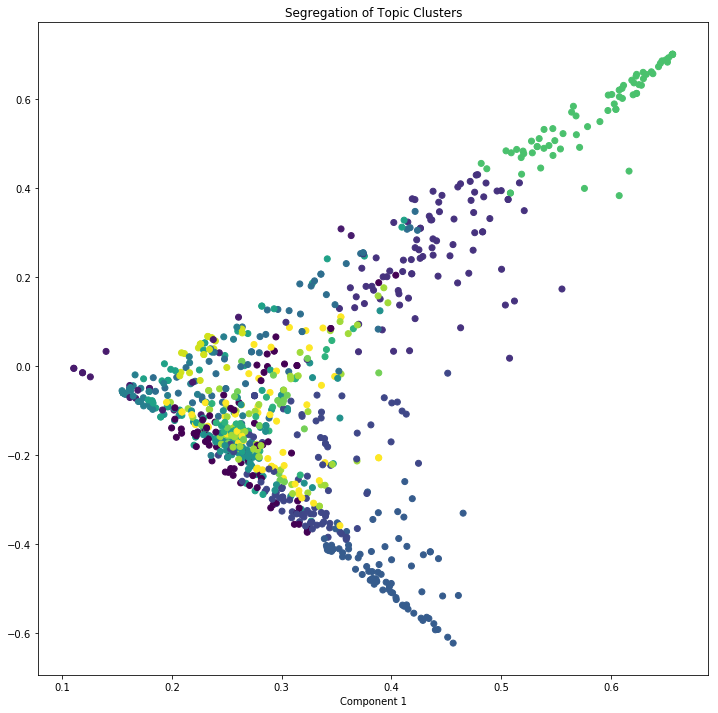

In [53]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )